In [1]:
import re
import math
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jieba
import plotly.express as px
import matplotlib.pyplot as plt

from io import StringIO
from opencc import OpenCC
from tqdm.auto import tqdm
from sklearn.utils import resample
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer

tqdm.pandas()

In [2]:
random_seed = 42

In [3]:
df = pd.read_csv('comment_sample.csv.gz', compression = 'gzip') # 不解壓縮直接讀取
df.reset_index(inplace = True)
df.rename(columns = {'index': 'ind'}, inplace = True)
df.sample(10, random_state = random_seed)

,ind,score,title,content
7492,7492,100,很棒的酒店 非常方便,我和我的家人在這家酒店住的時候就是九月第一週酒店很高 因爲我們帶着一個嬰兒 我給他們發了郵件...
83198,83198,100,物超所值,超值 嶄新 房間很大 要是住名氣大的酒店 雖然房間大小可能是一樣的 但是價格卻要貴2倍 付同...
113016,113016,60,地理位置不錯 風景很美,這家酒店給了我10 的生日折扣 酒店提供免費的小型瑞士花園和青青草原門票 很享受那裡的台灣菜...
71106,71106,20,失望透頂,價值不到1800的飯店 門開不了 霉味 衛生 隔音 廁所小蟲異味 沒洗手肥皂 積水 根本無法...
3057,3057,100,特別在許多層面上,在價格方面 清潔度 舒適度幸福的家庭旅館真是出色的 價格明顯低於可比較的旅館這裏又很安靜 舒...
44272,44272,100,房間住宿,環境舒適優雅 服務人員服務熱心親切 交通停車也算方便 家庭住宿旅遊新莊首選 餐飲服務值物起所...
148707,148707,80,夜機最好選擇,很近機場 職員有禮貌 房間很大很乾淨 廁所和浴缸也很大 早餐選擇多也好味 可惜是酒店沒有提供...
139851,139851,60,MIDO 米豆文旅,台東輕旅行 小資選擇口袋名單之一 選擇住宿因素 1 房間空間不會太小 2 房價具有競爭力 3...
44384,44384,100,很有特色 員工友善 就在小巨蛋附近的一家飯店,這一次旅行是因為到小巨蛋看演唱會 所以就選了一家在小巨蛋附近的飯店 飯店位置距離捷運南京三民...
142266,142266,80,舒適漂亮且充滿人情味的地方,房間相當舒適漂亮 床很好睡 有大大的停車空間 距離傳統藝術中心 冬山河 和羅東夜市都很近 交...


In [4]:
df['title'].fillna('', inplace = True)
df['content'].fillna('', inplace = True)

df['text'] = df[['title', 'content']].agg('-'.join, axis = 1)
# agg可以一次做兩件事，例如組合兩列文本、'-'分隔符號
df['polarity'] = df.score.apply(lambda x :1 if x > 60 else -1)
# apply()函數在給定系列對象的每個元素上調用傳遞的函數，apply()最特別在於可以同時處理多列數據
# lamda 簡易函數

df.head()

,ind,score,title,content,text,polarity
0,0,100,難忘的求婚之旅,清靜的房間乾淨 整潔 泡湯池跟大露台更是一大享受 感謝您們貼心的服務準備了餐盒 有機會一定再次造訪,難忘的求婚之旅-清靜的房間乾淨 整潔 泡湯池跟大露台更是一大享受 感謝您們貼心的服務準備了餐...,1
1,1,100,推薦,來到台中可以來住這邊 離逢甲很近走路可以到 房間整天很乾淨舒適非常推薦 建議來台中玩可以住這...,推薦-來到台中可以來住這邊 離逢甲很近走路可以到 房間整天很乾淨舒適非常推薦 建議來台中玩可...,1
2,2,60,商務酒店 想通了還是挺舒服的,這是商務酒店 和日本的商務酒店幾乎一樣 免費上網 但網速不穩定 有時候還連不上 我就過去睡了...,商務酒店 想通了還是挺舒服的-這是商務酒店 和日本的商務酒店幾乎一樣 免費上網 但網速不穩定...,-1
3,3,60,二日遊,入住時 服務人員的態度都很好 到房間後發現備品有少 打到櫃台跟服務人員說後 很快就拿到了 非...,二日遊-入住時 服務人員的態度都很好 到房間後發現備品有少 打到櫃台跟服務人員說後 很快就拿...,-1
4,4,60,很漂亮,外觀很漂亮 但是整潔來說還可以接受 但是樓上沖水聲音都聽的到 廁所地板感覺都沙沙的 冰箱有很...,很漂亮-外觀很漂亮 但是整潔來說還可以接受 但是樓上沖水聲音都聽的到 廁所地板感覺都沙沙的 ...,-1


In [5]:
train_df, valid_df = train_test_split(
    df, test_size = .2, random_state = random_seed)

print(valid_df.polarity.value_counts()) # value_counts:按值排序

 1    22659
-1     7337
Name: polarity, dtype: int64


In [6]:
print(f'traing set size:{len(train_df)}')
print(f'validation set size:{len(valid_df)}')

traing set size:119980
validation set size:29996


In [7]:
url = 'https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big'
response = requests.get(url)
with open('dict.txt.big', 'w', encoding = 'utf-8') as f:
    f.write(response.text)
    
url = 'https://raw.githubusercontent.com/goto456/stopwords/master/baidu_stopwords.txt'
response = requests.get(url)
io_obj = StringIO(response.text)
stopwords = io_obj.getvalue().split('\n')

In [8]:
stopwords[:10]

['--', '?', '“', '”', '》', '－－', 'able', 'about', 'above', 'according']

In [9]:
def _jieba_cut_words(s):
    cut_words = jieba.cut(s, cut_all=False)
    result = []
    for word in cut_words:
        word = word.strip()# len(word) > 1是為了篩選有意義的詞彙
        if len(word) > 1 and word not in stopwords:
            result += [word]
    return ' '.join(result)


def _cc_transform(x):
    return cc.convert(x)

def _remove_punctuation(x):
    removed = re.sub(pattern, ' ', x)
    return re.sub('[^\w\s]', ' ', removed)
def cleansing(data):
    removed = _remove_punctuation(data)
    converted = _cc_transform(removed)
    cut_words = _jieba_cut_words(converted)
    return cut_words

dict_path = 'dict.txt.big'

jieba.set_dictionary(dict_path)
# 在0.28之前的版本是不能指定主辭典的路徑的，有了延遲加載器之後，可以改變主辭典的路徑
jieba.initialize() # 手動初始化

cc = OpenCC('s2twp') # s2twp, tw2sp 繁簡轉換利器OpenCC

pattern = '[{}]'.format(string.punctuation)
pattern = pattern.replace('.', '').replace('-', '')

stopwords = [cc.convert(word) for word in stopwords]

train_df['bow'] = train_df.text.progress_apply(cleansing)
# progress_apply()運行程序的過程中，下方出現監視的進度條
valid_df['bow'] = valid_df.text.progress_apply(cleansing)

Building prefix dict from C:\Users\USER\Desktop\0626\dict.txt.big ...
Dumping model to file cache C:\Users\USER\AppData\Local\Temp\jieba.ue8ff6a041586a32eea68b750a33d9b10.cache
Loading model cost 1.357 seconds.
Prefix dict has been built successfully.


  0%|          | 0/119980 [00:00<?, ?it/s]

  0%|          | 0/29996 [00:00<?, ?it/s]

In [10]:
valid_df

,ind,score,title,content,text,polarity,bow
7492,7492,100,很棒的酒店 非常方便,我和我的家人在這家酒店住的時候就是九月第一週酒店很高 因爲我們帶着一個嬰兒 我給他們發了郵件...,很棒的酒店 非常方便-我和我的家人在這家酒店住的時候就是九月第一週酒店很高 因爲我們帶着一個...,1,很棒 酒店 家人 這家 酒店 九月 第一週 酒店 帶著 一個 嬰兒 我給 發了 郵件 提前 ...
83198,83198,100,物超所值,超值 嶄新 房間很大 要是住名氣大的酒店 雖然房間大小可能是一樣的 但是價格卻要貴2倍 付同...,物超所值-超值 嶄新 房間很大 要是住名氣大的酒店 雖然房間大小可能是一樣的 但是價格卻要貴...,1,物超所值 超值 嶄新 房間 很大 名氣 酒店 房間 大小 價格 價格 東邊 只能 一家 裝修...
113016,113016,60,地理位置不錯 風景很美,這家酒店給了我10 的生日折扣 酒店提供免費的小型瑞士花園和青青草原門票 很享受那裡的台灣菜...,地理位置不錯 風景很美-這家酒店給了我10 的生日折扣 酒店提供免費的小型瑞士花園和青青草原...,-1,地理位置 不錯 風景 這家 酒店 給了 10 生日 折扣 酒店 提供 免費 小型 瑞士 花園...
71106,71106,20,失望透頂,價值不到1800的飯店 門開不了 霉味 衛生 隔音 廁所小蟲異味 沒洗手肥皂 積水 根本無法...,失望透頂-價值不到1800的飯店 門開不了 霉味 衛生 隔音 廁所小蟲異味 沒洗手肥皂 積水...,-1,失望透頂 價值 不到 1800 飯店 門開 不了 黴味 衛生 隔音 廁所 小蟲 異味 洗手 ...
3057,3057,100,特別在許多層面上,在價格方面 清潔度 舒適度幸福的家庭旅館真是出色的 價格明顯低於可比較的旅館這裏又很安靜 舒...,特別在許多層面上-在價格方面 清潔度 舒適度幸福的家庭旅館真是出色的 價格明顯低於可比較的旅...,1,特別 層面 價格 清潔度 舒適度 幸福 家庭旅館 出色 價格 低於 旅館 安靜 舒適 乾淨 ...
...,...,...,...,...,...,...,...
17183,17183,80,入住送i cach卡 填寫評論送限量環保袋,客房寬敞 床很舒服 水夠大夠熱有浴缸 小孩和家人都很喜歡 內有停車場 早餐樣式多 但美中不足...,入住送i cach卡 填寫評論送限量環保袋-客房寬敞 床很舒服 水夠大夠熱有浴缸 小孩和家人...,1,入住 cach 填寫 評論 限量 環保 客房 寬敞 舒服 水夠 大夠 熱有 浴缸 小孩 家人...
108881,108881,100,對於在機場轉機的旅客 這是極好的位置,酒店距離機場輕軌和高速火車站步行7分鐘可到 在那裡可以向北到台北和更遠的地方 80分鐘左右可...,對於在機場轉機的旅客 這是極好的位置-酒店距離機場輕軌和高速火車站步行7分鐘可到 在那裡可以...,1,機場 轉機 旅客 這是 極好 位置 酒店 距離 機場 輕軌 高速 火車站 步行 分鐘 北到 ...
15365,15365,100,愉快的旅行,環境乾淨整潔很舒適 每個服務人員也都很貼心 很難得一邊住宿還可以一邊欣賞動物 飯店裡還有很多...,愉快的旅行-環境乾淨整潔很舒適 每個服務人員也都很貼心 很難得一邊住宿還可以一邊欣賞動物 飯...,1,愉快 旅行 環境 乾淨 整潔 舒適 服務 人員 貼心 難得 住宿 欣賞 動物 飯店 很多 活...
141768,141768,100,很棒的旅館住在Horizon,在這裏住了4晚聖誕期間臺北 和想重點多少我很喜歡住在Horizon Inn 要大大地感謝那兒...,很棒的旅館住在Horizon-在這裏住了4晚聖誕期間臺北 和想重點多少我很喜歡住在Horiz...,1,很棒 旅館 Horizon 聖誕 期間 臺北 重點 喜歡 Horizon Inn 感謝 優秀...


## Check the label number

<Axes: ylabel='count'>

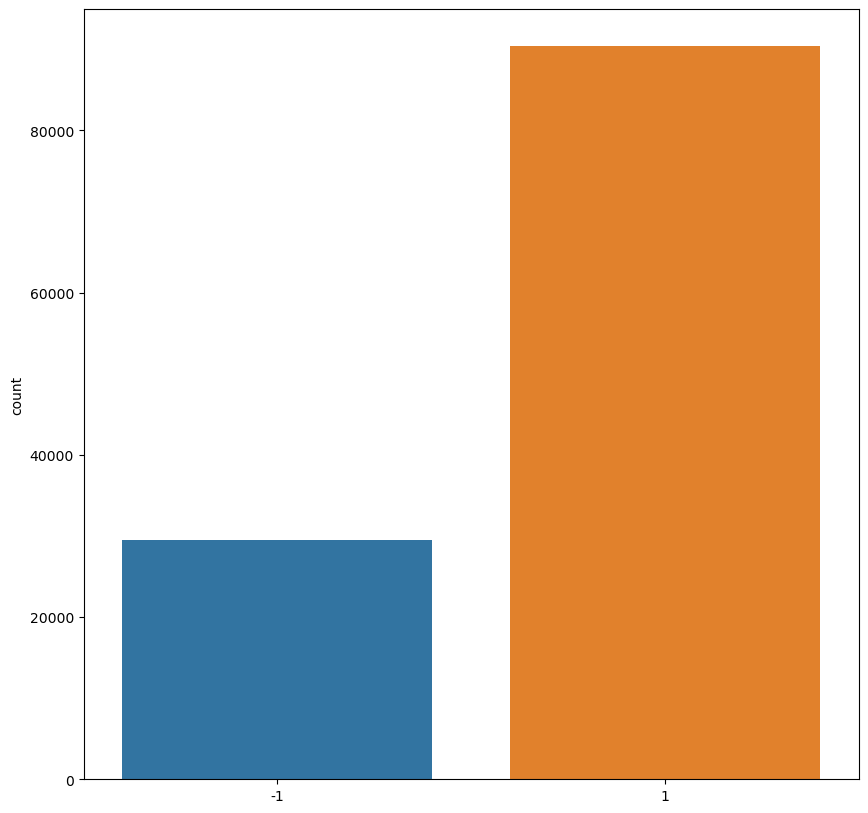

In [11]:
plt.figure(figsize = (10, 10))
sns.countplot(x = train_df.polarity.values)


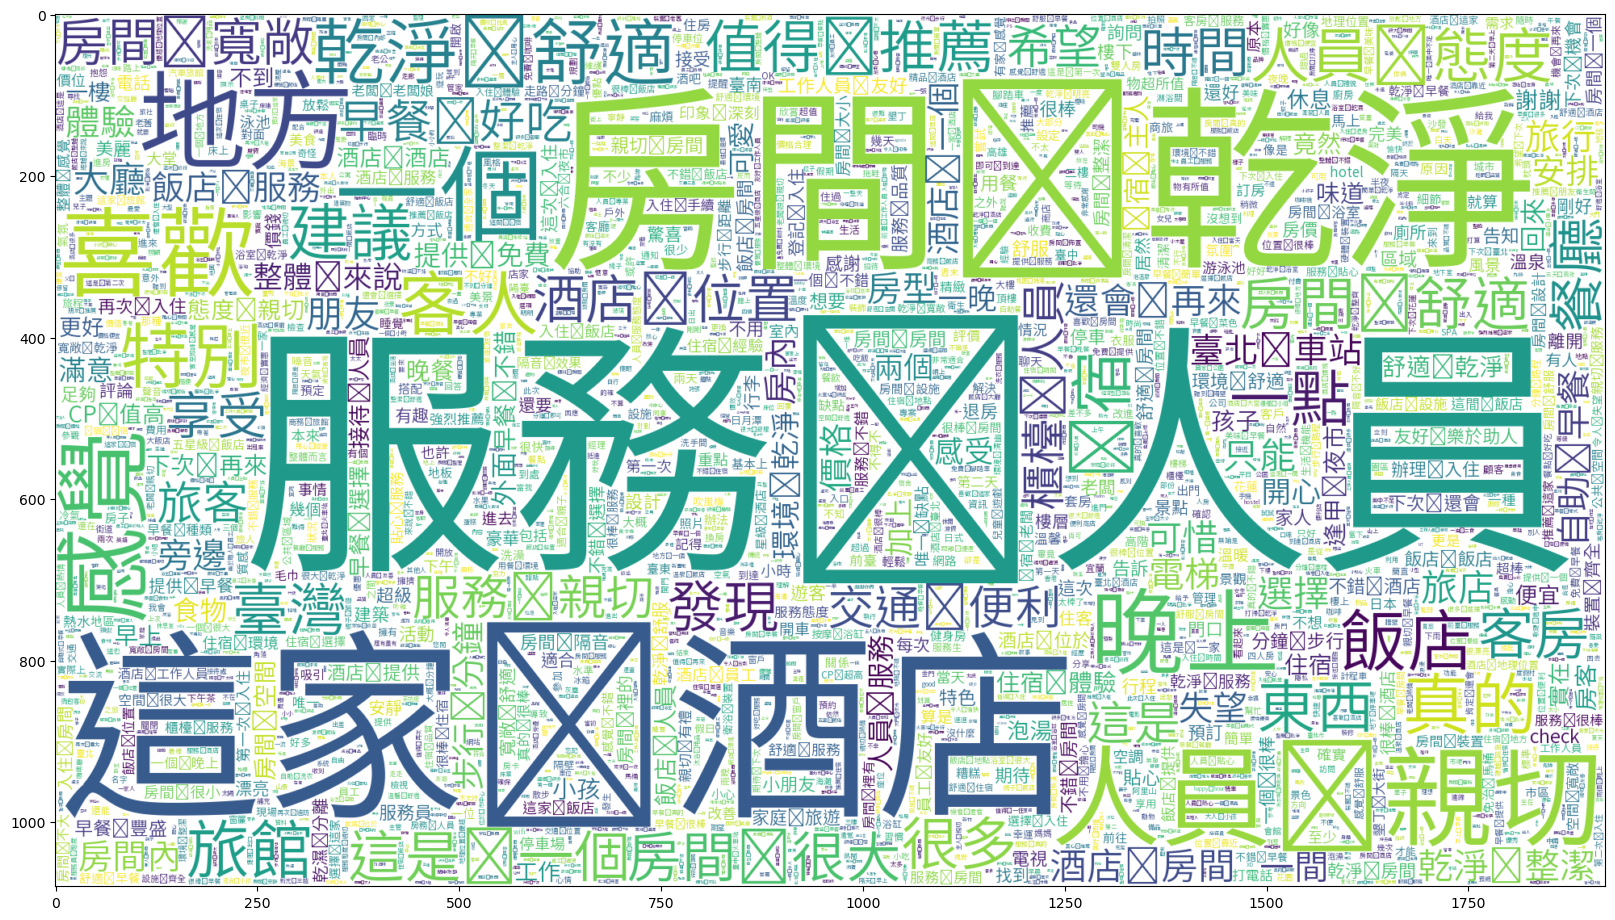

In [16]:
url = 'https://raw.githubusercontent.com/g0v/moedict.tw/master/SourceHanSansTW-Normal.ttf'

response = requests.get(url)
with open('SourceHanSansTW-Normal.ttf', 'wb') as f:
    f.write(response.content)

plt.figure(figsize = (20, 20))
wc = WordCloud(
    stopwords = STOPWORDS, font_path = 'SourceHanSansTW-Normal.ttf',
    max_words = 2560, width = 1920, height = 1080, background_color = 'white')
wc = wc.generate(' '.join(train_df.bow)) # 方便生成迭代器
plt.imshow(wc, interpolation = 'bilinear')

wc.to_file('cw.png')